In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset,random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import numpy as np
import pandas as pd
import random 
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Creation of Train and Validation set

In [4]:
# Store the metadata in a dataframe
df = pd.read_csv('metadata.csv')

# Store how many images have the same latitude and longitude
paths = df.groupby(["lat","lon","plume"]).count()[['path']].sort_values("path", ascending = False)

# Initialize an empty column to store all images path
paths['lists'] = np.nan

temp = []

# Save all images paths that have the same lat and lon in one list
for i,row in enumerate(paths.iterrows()):  
  row = row[0]
  temp.append(list(df['path'][(df['lat'] == row[0]) & (df['lon'] == row[1])]))

paths['lists'] = temp

# We don't want anymore the lat, lon and plume to be an index so we are resetting the dataframe
paths = paths.reset_index()

In [5]:
paths.head()

,lat,lon,plume,path,lists
0,29.631951,35.952379,no,21,[images/no_plume/20230304_methane_mixing_ratio...
1,32.713854,44.609398,no,19,[images/no_plume/20230219_methane_mixing_ratio...
2,33.990812,39.641866,no,18,[images/no_plume/20230206_methane_mixing_ratio...
3,28.510000,77.442400,yes,17,[images/plume/20230327_methane_mixing_ratio_id...
4,36.596520,38.321405,no,15,[images/no_plume/20230122_methane_mixing_ratio...


## 1st Split: Split by Location

In [ ]:
# We are taking 20% of the locations (10% of plume locations and 10% of no plume locations) as a validation
# set
val_indexs = list(paths[paths['plume'] == 'yes'].sample(int(len(paths)*0.1)).index) +\
list(paths[paths['plume'] == 'no'].sample(int(len(paths)*0.1)).index)

In [ ]:
import os
import random
import shutil

# Set up paths
data_dir = 'images'
val_dir = 'validation'
train_dir='train'

plume_dir = 'plume'
no_plume_dir = 'no_plume'

# Create validation directories
os.makedirs(os.path.join(train_dir, plume_dir), exist_ok=True)
os.makedirs(os.path.join(train_dir, no_plume_dir), exist_ok=True)
os.makedirs(os.path.join(val_dir, plume_dir), exist_ok=True)
os.makedirs(os.path.join(val_dir, no_plume_dir), exist_ok=True)

# Get filenames from true and false directories
val_plume_files = set([y.strip("images/plume/")+str('.tif') for x in list(paths.lists[paths.index.isin(val_indexs[:10])]) for y in x])
val_no_plume_files = set([y.strip("images/no_plume/")+str('.tif') for x in list(paths.lists[paths.index.isin(val_indexs[10:])]) for y in x])
train_files = paths[~paths.index.isin(val_indexs)]
train_plume_files = set([y.strip("images/plume/")+str('.tif') for x in list(train_files.lists[train_files.plume == "yes"]) for y in x])
train_no_plume_files = set([y.strip("images/no_plume/")+str('.tif') for x in list(train_files.lists[train_files.plume == "no"]) for y in x])

# Move sampled files to validation directories
for filename in val_plume_files:
    shutil.move(os.path.join(data_dir, plume_dir, filename),
                os.path.join( val_dir, plume_dir))
for filename in val_no_plume_files:
    shutil.move(os.path.join(data_dir, no_plume_dir, filename),
                os.path.join(val_dir, no_plume_dir))
for filename in train_plume_files:
    shutil.move(os.path.join(data_dir, plume_dir, filename),
                os.path.join( train_dir, plume_dir))
for filename in train_no_plume_files:
    shutil.move(os.path.join(data_dir, no_plume_dir, filename),
                os.path.join(train_dir, no_plume_dir))

## 2nd Split: Split By Having each location in training set

In [9]:
val_index = [] 

# For each location, I am taking 35% of the images paths for the validation set
# Why 35%? Because some locations have only one image so we want it to be in the training set, and if
# we take 20% of each location, we will end up with less than this percentage because of these locations,
# so to compensate this we decided to take 35%
for x in list(paths.lists):
  val_index.extend(set(list(random.sample(x, int(len(x)*0.35)))))

In [10]:
# We are saving all the images paths that are not in the validation set for the training set 
# This is done by removing from all the set of images paths the ones of the validation set

L = set([y for x in paths.lists for y in x])

for item in val_index:
    if item in L:
        L.remove(item)

In [12]:
# A 20% split proven
print("The number of images in total: ", len(set([y for x in paths.lists for y in x])))
print("The number of images in the train set: ", len(L))
print("The number of images in the validation set: ", len(val_index))

The number of images in total:  428
The number of images in the train set:  319
The number of images in the validation set:  109


In [ ]:
import os
import random
import shutil

# Set up paths
data_dir = 'images'
val_dir = 'validation_each_location'
train_dir='train_each_location'

plume_dir = 'plume'
no_plume_dir = 'no_plume'

val_plume_files = []
val_no_plume_files = []
train_plume_files = []
train_no_plume_files = []

# Create validation directories
os.makedirs(os.path.join(train_dir, plume_dir), exist_ok=True)
os.makedirs(os.path.join(train_dir, no_plume_dir), exist_ok=True)
os.makedirs(os.path.join(val_dir, plume_dir), exist_ok=True)
os.makedirs(os.path.join(val_dir, no_plume_dir), exist_ok=True)

# Splitting the validation set into plume and no plume
for val in val_index:
  if 'no_plume' in val:
    val_no_plume_files.append(val)
  else:
    val_plume_files.append(val)

# Splitting the training set into plume and no plume
for val in L:
  if 'no_plume' in val:
    train_no_plume_files.append(val)
  else:
    train_plume_files.append(val)

# Removing 'images/plume/' and 'images/no_plume/' from paths
val_plume_files = set([y.strip("images/plume/")+str('.tif') for y in val_plume_files])
val_no_plume_files = set([y.strip("images/no_plume/")+str('.tif') for y in val_no_plume_files])
train_plume_files = set([y.strip("images/plume/")+str('.tif') for y in train_plume_files])
train_no_plume_files = set([y.strip("images/no_plume/")+str('.tif') for y in train_no_plume_files])

# Move sampled files to validation directories
for filename in val_plume_files:
    shutil.move(os.path.join(data_dir, plume_dir, filename),
                os.path.join( val_dir, plume_dir))
for filename in val_no_plume_files:
    shutil.move(os.path.join(data_dir, no_plume_dir, filename),
                os.path.join(val_dir, no_plume_dir))
for filename in train_plume_files:
    shutil.move(os.path.join(data_dir, plume_dir, filename),
                os.path.join( train_dir, plume_dir)) 
for filename in train_no_plume_files:
    shutil.move(os.path.join(data_dir, no_plume_dir, filename),
                os.path.join(train_dir, no_plume_dir)) 

# Dataset and Dataloader

In this notebook, we will only show the results we got with the first split (split by location) because it will create the most robust model since the model will be trained on specific locations and be able to correctly predict other locations, rather than training the model on all locations and testing on the same location 

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.augment = augment
        self.image_list = []
        self.labels = []
        self.augmented_images = []

        plume_images = []
        no_plume_images = []

        classes = os.listdir(root_dir)
        for class_name in classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                image_names = os.listdir(class_dir)
                tiff_image_names = [img_name for img_name in image_names if img_name.lower().endswith('.tiff') or img_name.lower().endswith('.tif')]

                if class_name == 'plume':
                    plume_images.extend([os.path.join(class_dir, img_name) for img_name in tiff_image_names])
                else:
                    no_plume_images.extend([os.path.join(class_dir, img_name) for img_name in tiff_image_names])

                self.labels.extend([1 if class_name == 'plume' else 0] * len(tiff_image_names))

        # Calculate the number of images in each class
        num_images = min(len(plume_images), len(no_plume_images))

        if augment:
            augmented_images = []
            for _ in range(num_images):
                # Randomly select plume and no plume images
                plume_image_path = random.choice(plume_images)
                no_plume_image_path = random.choice(no_plume_images)

                # Load and augment plume image
                plume_image = Image.open(plume_image_path)
                plume_image = plume_image.resize((64, 64))  # Resize to 64x64
                transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor()
                ])
                augmented_plume_image = transform(plume_image)
                augmented_images.append(augmented_plume_image)

                # Load and augment no plume image
                no_plume_image = Image.open(no_plume_image_path)
                no_plume_image = no_plume_image.resize((64, 64))  # Resize to 64x64
                augmented_no_plume_image = transform(no_plume_image)
                augmented_images.append(augmented_no_plume_image)

            self.augmented_images = augmented_images

        self.image_list = plume_images[:num_images] + no_plume_images[:num_images]
        self.labels = [1] * num_images + [0] * num_images

        if augment:
            num_augmented_images = len(self.augmented_images)
            self.image_list.extend(self.augmented_images)
            self.labels.extend(self.labels[:num_augmented_images])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        label = self.labels[idx]

        if isinstance(image, str):
            image = Image.open(image)
            image = image.resize((64, 64))  # Resize to 64x64

            transform = transforms.Compose([
                transforms.ToTensor()
            ])
            image = transform(image)

        return image, label

In [5]:
root_dir = "train_val/train"
val_dir = "train_val/validation"

train_dataset = CustomDataset(root_dir, augment=True)
val_dataset = CustomDataset(val_dir, augment=False)


# Define batch size for training and validation
batch_size = 32

# Create the train DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Verify the train and validation data loaders
for images, labels in train_loader:
    print(f"Train batch - Images: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in val_loader:
    print(f"Validation batch - Images: {images.shape}, Labels: {labels.shape}")
    break

Train batch - Images: torch.Size([32, 1, 64, 64]), Labels: torch.Size([32])
Validation batch - Images: torch.Size([32, 1, 64, 64]), Labels: torch.Size([32])


We can check that our train dataset is balanced between plume and no plume

In [8]:
num_plumes = sum(label == 1 for label in train_dataset.labels)
num_no_plumes = sum(label == 0 for label in train_dataset.labels)

print("Number of training samples:", len(train_dataset))
print(f"Number of plumes: {num_plumes}")
print(f"Number of no plumes: {num_no_plumes}")

Number of training samples: 528
Number of plumes: 264
Number of no plumes: 264


# Models

## Wide_ResNet50

In [11]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
resnet50 = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.IMAGENET1K_V2')

# Modify the first layer to accept single-channel grayscale images
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, num_classes)
)

In [12]:
# Move the model to the device
resnet50 = resnet50.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

num_epochs = 40

In [13]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet50.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet50.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet50(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet50.state_dict(), f"resnet50_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:02<?, ?it/s]

Epoch 1/40 - Average Loss: 0.5787305757403374
Validation AUC: 0.828551912568306



Epochs:   2%|█▉                                                                         | 1/40 [00:02<01:48,  2.78s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:04<01:48,  2.78s/it]

Epoch 2/40 - Average Loss: 0.28013772442936896
Validation AUC: 0.90198087431694



Epochs:   5%|███▊                                                                       | 2/40 [00:05<01:38,  2.58s/it]

Saved


Epochs:   8%|█████▋                                                                     | 3/40 [00:07<01:28,  2.38s/it]

Epoch 3/40 - Average Loss: 0.1250903150998056
Validation AUC: 0.8767076502732241


Epochs:  10%|███████▌                                                                   | 4/40 [00:09<01:22,  2.30s/it]

Epoch 4/40 - Average Loss: 0.0992663905955851
Validation AUC: 0.8831967213114754


Epochs:  12%|█████████▍                                                                 | 5/40 [00:11<01:18,  2.25s/it]

Epoch 5/40 - Average Loss: 0.08321124077774585
Validation AUC: 0.8084016393442623


Epochs:  15%|███████████▎                                                               | 6/40 [00:13<01:15,  2.22s/it]

Epoch 6/40 - Average Loss: 0.13790159225463866
Validation AUC: 0.8697062841530054


Epochs:  15%|███████████▎                                                               | 6/40 [00:15<01:15,  2.22s/it]

Epoch 7/40 - Average Loss: 0.13440130772069098
Validation AUC: 0.9156420765027322



Epochs:  18%|█████████████▏                                                             | 7/40 [00:16<01:15,  2.30s/it]

Saved


Epochs:  20%|███████████████                                                            | 8/40 [00:18<01:12,  2.25s/it]

Epoch 8/40 - Average Loss: 0.06306553832255304
Validation AUC: 0.8835382513661202


Epochs:  22%|████████████████▉                                                          | 9/40 [00:20<01:09,  2.23s/it]

Epoch 9/40 - Average Loss: 0.025845903910521884
Validation AUC: 0.905396174863388


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:22<01:06,  2.21s/it]

Epoch 10/40 - Average Loss: 0.05281592024257407
Validation AUC: 0.8633879781420765


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:24<01:03,  2.19s/it]

Epoch 11/40 - Average Loss: 0.14582735393196344
Validation AUC: 0.8616803278688525


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:27<01:01,  2.19s/it]

Epoch 12/40 - Average Loss: 0.0824924575863406
Validation AUC: 0.9011270491803278


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:29<01:01,  2.19s/it]

Epoch 13/40 - Average Loss: 0.08090225947089494
Validation AUC: 0.923155737704918



Epochs:  32%|████████████████████████                                                  | 13/40 [00:29<01:01,  2.27s/it]

Saved


Epochs:  32%|████████████████████████                                                  | 13/40 [00:31<01:01,  2.27s/it]

Epoch 14/40 - Average Loss: 0.058613514568423855
Validation AUC: 0.9330601092896175



Epochs:  35%|█████████████████████████▉                                                | 14/40 [00:32<01:00,  2.33s/it]

Saved


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:34<00:57,  2.28s/it]

Epoch 15/40 - Average Loss: 0.04621050472487696
Validation AUC: 0.9286202185792349


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:36<00:53,  2.25s/it]

Epoch 16/40 - Average Loss: 0.038422490970697255
Validation AUC: 0.9241803278688524


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [00:38<00:51,  2.22s/it]

Epoch 17/40 - Average Loss: 0.12927299486182164
Validation AUC: 0.9129098360655737


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [00:40<00:48,  2.20s/it]

Epoch 18/40 - Average Loss: 0.12666196338832378
Validation AUC: 0.9323770491803278


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [00:42<00:46,  2.19s/it]

Epoch 19/40 - Average Loss: 0.08456974965520203
Validation AUC: 0.9293032786885246


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [00:45<00:43,  2.18s/it]

Epoch 20/40 - Average Loss: 0.08038457448128611
Validation AUC: 0.91051912568306


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [00:47<00:41,  2.17s/it]

Epoch 21/40 - Average Loss: 0.01666154582053423
Validation AUC: 0.9122267759562842


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [00:49<00:39,  2.17s/it]

Epoch 22/40 - Average Loss: 0.017274305767205077
Validation AUC: 0.9043715846994536


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [00:51<00:36,  2.17s/it]

Epoch 23/40 - Average Loss: 0.03966298401355743
Validation AUC: 0.9176912568306012


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [00:53<00:34,  2.18s/it]

Epoch 24/40 - Average Loss: 0.01707356911501847
Validation AUC: 0.9122267759562842


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [00:55<00:32,  2.17s/it]

Epoch 25/40 - Average Loss: 0.00823339261842193
Validation AUC: 0.9182035519125682


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [00:58<00:30,  2.18s/it]

Epoch 26/40 - Average Loss: 0.010562544704498578
Validation AUC: 0.917691256830601


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:00<00:28,  2.18s/it]

Epoch 27/40 - Average Loss: 0.04113309113781725
Validation AUC: 0.8982240437158471


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [01:02<00:26,  2.18s/it]

Epoch 28/40 - Average Loss: 0.06920053004578222
Validation AUC: 0.9012978142076502


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [01:04<00:24,  2.19s/it]

Epoch 29/40 - Average Loss: 0.12162979381391778
Validation AUC: 0.8954918032786886


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [01:06<00:21,  2.20s/it]

Epoch 30/40 - Average Loss: 0.04413700605509803
Validation AUC: 0.9115437158469946


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:09<00:19,  2.20s/it]

Epoch 31/40 - Average Loss: 0.017174344324303092
Validation AUC: 0.9135928961748634


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:11<00:17,  2.20s/it]

Epoch 32/40 - Average Loss: 0.034135619662993125
Validation AUC: 0.9214480874316939


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [01:13<00:15,  2.19s/it]

Epoch 33/40 - Average Loss: 0.012315668905648636
Validation AUC: 0.9141051912568305


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [01:15<00:13,  2.18s/it]

Epoch 34/40 - Average Loss: 0.014732064047348104
Validation AUC: 0.9187158469945356


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [01:17<00:10,  2.17s/it]

Epoch 35/40 - Average Loss: 0.011292414813033247
Validation AUC: 0.9234972677595629


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [01:19<00:08,  2.18s/it]

Epoch 36/40 - Average Loss: 0.0063504476129310206
Validation AUC: 0.9166666666666666


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [01:22<00:06,  2.17s/it]

Epoch 37/40 - Average Loss: 0.012565116794303322
Validation AUC: 0.9064207650273224


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [01:24<00:04,  2.17s/it]

Epoch 38/40 - Average Loss: 0.010506757953680789
Validation AUC: 0.915983606557377


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [01:26<00:02,  2.17s/it]

Epoch 39/40 - Average Loss: 0.01539554665337164
Validation AUC: 0.91974043715847


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [01:28<00:00,  2.22s/it]

Epoch 40/40 - Average Loss: 0.00597173698079132
Validation AUC: 0.9217896174863387


## ResNet101

In [8]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet101 = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, num_classes)
)

In [9]:
# Move the model to the device
resnet101 = resnet101.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

num_epochs = 40

In [10]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet101.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet101(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet101.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet101(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet101.state_dict(), f"resnet101_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:03<?, ?it/s]

Epoch 1/40 - Average Loss: 0.5523270070552826
Validation AUC: 0.7253994953742641



Epochs:   2%|█▉                                                                         | 1/40 [00:03<02:15,  3.48s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:06<02:15,  3.48s/it]

Epoch 2/40 - Average Loss: 0.2706263784319162



Epochs:   5%|███▊                                                                       | 2/40 [00:06<02:06,  3.34s/it]

Validation AUC: 0.7228763666947015


Epochs:   5%|███▊                                                                       | 2/40 [00:09<02:06,  3.34s/it]

Epoch 3/40 - Average Loss: 0.20702776201069356



Epochs:   8%|█████▋                                                                     | 3/40 [00:09<02:00,  3.25s/it]

Validation AUC: 0.7186711522287637


Epochs:   8%|█████▋                                                                     | 3/40 [00:12<02:00,  3.25s/it]

Epoch 4/40 - Average Loss: 0.1834823599085212
Validation AUC: 0.8216989066442388



Epochs:  10%|███████▌                                                                   | 4/40 [00:13<01:55,  3.21s/it]

Saved


Epochs:  12%|█████████▍                                                                 | 5/40 [00:16<01:50,  3.15s/it]

Epoch 5/40 - Average Loss: 0.07309574214741588
Validation AUC: 0.796888141295206


Epochs:  12%|█████████▍                                                                 | 5/40 [00:18<01:50,  3.15s/it]

Epoch 6/40 - Average Loss: 0.044536938238888976
Validation AUC: 0.751892346509672


Epochs:  15%|███████████▎                                                               | 6/40 [00:21<01:45,  3.10s/it]

Epoch 7/40 - Average Loss: 0.04342429502867162
Validation AUC: 0.8465096719932717



Epochs:  18%|█████████████▏                                                             | 7/40 [00:22<01:44,  3.16s/it]

Saved


Epochs:  20%|███████████████                                                            | 8/40 [00:25<01:41,  3.18s/it]

Epoch 8/40 - Average Loss: 0.05828734738752246
Validation AUC: 0.7771236333052987


Epochs:  22%|████████████████▉                                                          | 9/40 [00:28<01:37,  3.15s/it]

Epoch 9/40 - Average Loss: 0.059220426809042694
Validation AUC: 0.7783851976450799


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:31<01:34,  3.14s/it]

Epoch 10/40 - Average Loss: 0.1396665668929927
Validation AUC: 0.6843986543313709


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:34<01:28,  3.07s/it]

Epoch 11/40 - Average Loss: 0.17337757535278797
Validation AUC: 0.7636669470142977


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:37<01:25,  3.04s/it]

Epoch 12/40 - Average Loss: 0.10244550034403802
Validation AUC: 0.7754415475189235


Epochs:  32%|████████████████████████                                                  | 13/40 [00:40<01:22,  3.05s/it]

Epoch 13/40 - Average Loss: 0.12263240367174148
Validation AUC: 0.802775441547519


Epochs:  35%|█████████████████████████▉                                                | 14/40 [00:43<01:20,  3.09s/it]

Epoch 14/40 - Average Loss: 0.12623733012005686
Validation AUC: 0.689655172413793


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:46<01:16,  3.06s/it]

Epoch 15/40 - Average Loss: 0.0376849245512858
Validation AUC: 0.7954163162321278


Epochs:  38%|███████████████████████████▊                                              | 15/40 [00:49<01:16,  3.06s/it]

Epoch 16/40 - Average Loss: 0.06687839741352945



Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:50<01:13,  3.08s/it]

Validation AUC: 0.7674516400336416


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [00:52<01:13,  3.08s/it]

Epoch 17/40 - Average Loss: 0.08576808744110168



Epochs:  42%|███████████████████████████████▍                                          | 17/40 [00:53<01:10,  3.09s/it]

Validation AUC: 0.8280067283431455


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [00:56<01:08,  3.12s/it]

Epoch 18/40 - Average Loss: 0.01599008858356683
Validation AUC: 0.8052985702270816


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [00:59<01:05,  3.10s/it]

Epoch 19/40 - Average Loss: 0.009573297189490404
Validation AUC: 0.7947855340622372


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:02<01:02,  3.12s/it]

Epoch 20/40 - Average Loss: 0.04521025060657848
Validation AUC: 0.6976450798990748


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:05<00:59,  3.11s/it]

Epoch 21/40 - Average Loss: 0.039187199145089835
Validation AUC: 0.8027754415475189


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:08<00:55,  3.10s/it]

Epoch 22/40 - Average Loss: 0.036194888246245685
Validation AUC: 0.8162321278385197


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:11<00:52,  3.08s/it]

Epoch 23/40 - Average Loss: 0.08760885982774198
Validation AUC: 0.7750210260723297


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:14<00:49,  3.09s/it]

Epoch 24/40 - Average Loss: 0.027204557844379453
Validation AUC: 0.7655592935239697


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:17<00:49,  3.09s/it]

Epoch 25/40 - Average Loss: 0.024025235952285583



Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:17<00:46,  3.07s/it]

Validation AUC: 0.7905803195962994


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:21<00:43,  3.09s/it]

Epoch 26/40 - Average Loss: 0.031207010442449244
Validation AUC: 0.6909167367535743


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:23<00:43,  3.09s/it]

Epoch 27/40 - Average Loss: 0.01760429588321131



Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:24<00:40,  3.11s/it]

Validation AUC: 0.75946173254836


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [01:27<00:37,  3.13s/it]

Epoch 28/40 - Average Loss: 0.013522298297903034
Validation AUC: 0.7685029436501262


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [01:30<00:34,  3.15s/it]

Epoch 29/40 - Average Loss: 0.006498128458770225
Validation AUC: 0.7584104289318755


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [01:33<00:31,  3.13s/it]

Epoch 30/40 - Average Loss: 0.004766667442981998
Validation AUC: 0.7455845248107653


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:36<00:28,  3.13s/it]

Epoch 31/40 - Average Loss: 0.0045402398810438175
Validation AUC: 0.7472666105971404


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [01:39<00:28,  3.13s/it]

Epoch 32/40 - Average Loss: 0.004557356079976671



Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:39<00:24,  3.11s/it]

Validation AUC: 0.7491589571068125


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [01:42<00:24,  3.11s/it]

Epoch 33/40 - Average Loss: 0.005011979792561761



Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [01:42<00:21,  3.07s/it]

Validation AUC: 0.7527333894028595


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [01:45<00:18,  3.07s/it]

Epoch 34/40 - Average Loss: 0.004743843967344219
Validation AUC: 0.7523128679562658


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [01:49<00:15,  3.09s/it]

Epoch 35/40 - Average Loss: 0.004281208277916448
Validation AUC: 0.7512615643397814


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [01:52<00:12,  3.12s/it]

Epoch 36/40 - Average Loss: 0.005620931055227629
Validation AUC: 0.7577796467619848


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [01:55<00:09,  3.13s/it]

Epoch 37/40 - Average Loss: 0.004429563104929457
Validation AUC: 0.7565180824222035


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [01:58<00:06,  3.12s/it]

Epoch 38/40 - Average Loss: 0.004528781477893063
Validation AUC: 0.7529436501261564


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:01<00:03,  3.12s/it]

Epoch 39/40 - Average Loss: 0.004464343424569961
Validation AUC: 0.7502102607232969


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:04<00:00,  3.12s/it]

Epoch 40/40 - Average Loss: 0.004889156664103211
Validation AUC: 0.75336417157275


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:04<00:00,  3.12s/it]


## ResNet152

In [11]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet152 = models.resnet152(weights='ResNet152_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet152.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet152.fc = nn.Sequential(
    nn.Linear(resnet152.fc.in_features, num_classes)
)

In [12]:
# Move the model to the device
resnet152 = resnet152.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(resnet152.parameters(), lr=0.001)

num_epochs = 40

In [13]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnet152.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnet152(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    resnet152.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet152(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(resnet152.state_dict(), f"resnet152_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved")
    

Epochs:   0%|                                                                                   | 0/40 [00:04<?, ?it/s]

Epoch 1/40 - Average Loss: 0.554765410721302
Validation AUC: 0.8322119428090833



Epochs:   2%|█▉                                                                         | 1/40 [00:04<03:13,  4.97s/it]

Saved


Epochs:   2%|█▉                                                                         | 1/40 [00:08<03:13,  4.97s/it]

Epoch 2/40 - Average Loss: 0.38640792220830916



Epochs:   5%|███▊                                                                       | 2/40 [00:09<02:52,  4.53s/it]

Validation AUC: 0.8183347350714887


Epochs:   5%|███▊                                                                       | 2/40 [00:13<02:52,  4.53s/it]

Epoch 3/40 - Average Loss: 0.2298201858997345
Validation AUC: 0.843986543313709



Epochs:   8%|█████▋                                                                     | 3/40 [00:13<02:49,  4.58s/it]

Saved


Epochs:   8%|█████▋                                                                     | 3/40 [00:17<02:49,  4.58s/it]

Epoch 4/40 - Average Loss: 0.17310999939218163



Epochs:  10%|███████▌                                                                   | 4/40 [00:18<02:40,  4.46s/it]

Validation AUC: 0.8036164844407064


Epochs:  10%|███████▌                                                                   | 4/40 [00:22<02:40,  4.46s/it]

Epoch 5/40 - Average Loss: 0.14540989762172102



Epochs:  12%|█████████▍                                                                 | 5/40 [00:22<02:34,  4.42s/it]

Validation AUC: 0.7985702270815812


Epochs:  12%|█████████▍                                                                 | 5/40 [00:26<02:34,  4.42s/it]

Epoch 6/40 - Average Loss: 0.09704861831851304



Epochs:  15%|███████████▎                                                               | 6/40 [00:26<02:27,  4.34s/it]

Validation AUC: 0.8107653490328007


Epochs:  15%|███████████▎                                                               | 6/40 [00:30<02:27,  4.34s/it]

Epoch 7/40 - Average Loss: 0.14081177450716495



Epochs:  18%|█████████████▏                                                             | 7/40 [00:30<02:23,  4.35s/it]

Validation AUC: 0.7905803195962994


Epochs:  18%|█████████████▏                                                             | 7/40 [00:35<02:23,  4.35s/it]

Epoch 8/40 - Average Loss: 0.0777827606187202



Epochs:  20%|███████████████                                                            | 8/40 [00:35<02:19,  4.37s/it]

Validation AUC: 0.7691337258200169


Epochs:  20%|███████████████                                                            | 8/40 [00:39<02:19,  4.37s/it]

Epoch 9/40 - Average Loss: 0.07569502533879131



Epochs:  22%|████████████████▉                                                          | 9/40 [00:39<02:15,  4.38s/it]

Validation AUC: 0.7510513036164845


Epochs:  22%|████████████████▉                                                          | 9/40 [00:43<02:15,  4.38s/it]

Epoch 10/40 - Average Loss: 0.10108553831232711



Epochs:  25%|██████████████████▌                                                       | 10/40 [00:44<02:09,  4.33s/it]

Validation AUC: 0.7582001682085787


Epochs:  25%|██████████████████▌                                                       | 10/40 [00:48<02:09,  4.33s/it]

Epoch 11/40 - Average Loss: 0.0767774699255824
Validation AUC: 0.9083263246425568



Epochs:  28%|████████████████████▎                                                     | 11/40 [00:48<02:08,  4.42s/it]

Saved


Epochs:  28%|████████████████████▎                                                     | 11/40 [00:52<02:08,  4.42s/it]

Epoch 12/40 - Average Loss: 0.07366225021251012



Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:52<02:02,  4.36s/it]

Validation AUC: 0.8021446593776282


Epochs:  30%|██████████████████████▏                                                   | 12/40 [00:56<02:02,  4.36s/it]

Epoch 13/40 - Average Loss: 0.05186026762239635



Epochs:  32%|████████████████████████                                                  | 13/40 [00:57<01:57,  4.34s/it]

Validation AUC: 0.8830950378469302


Epochs:  32%|████████████████████████                                                  | 13/40 [01:01<01:57,  4.34s/it]

Epoch 14/40 - Average Loss: 0.00964964997365314



Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:01<01:52,  4.32s/it]

Validation AUC: 0.8753153910849454


Epochs:  35%|█████████████████████████▉                                                | 14/40 [01:05<01:52,  4.32s/it]

Epoch 15/40 - Average Loss: 0.037316644046950384



Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:05<01:47,  4.30s/it]

Validation AUC: 0.8166526492851136


Epochs:  38%|███████████████████████████▊                                              | 15/40 [01:09<01:47,  4.30s/it]

Epoch 16/40 - Average Loss: 0.009191213780650288



Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:09<01:42,  4.28s/it]

Validation AUC: 0.8309503784693019


Epochs:  40%|█████████████████████████████▌                                            | 16/40 [01:13<01:42,  4.28s/it]

Epoch 17/40 - Average Loss: 0.032910164725035426



Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:14<01:38,  4.29s/it]

Validation AUC: 0.8284272497897393


Epochs:  42%|███████████████████████████████▍                                          | 17/40 [01:18<01:38,  4.29s/it]

Epoch 18/40 - Average Loss: 0.0604193399194628



Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:18<01:33,  4.27s/it]

Validation AUC: 0.8940285954583684


Epochs:  45%|█████████████████████████████████▎                                        | 18/40 [01:22<01:33,  4.27s/it]

Epoch 19/40 - Average Loss: 0.03353976102152956



Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:22<01:30,  4.33s/it]

Validation AUC: 0.8183347350714887


Epochs:  48%|███████████████████████████████████▏                                      | 19/40 [01:27<01:30,  4.33s/it]

Epoch 20/40 - Average Loss: 0.040444342097907794



Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:27<01:26,  4.35s/it]

Validation AUC: 0.8578637510513036


Epochs:  50%|█████████████████████████████████████                                     | 20/40 [01:31<01:26,  4.35s/it]

Epoch 21/40 - Average Loss: 0.044160327765712284



Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:31<01:23,  4.42s/it]

Validation AUC: 0.8187552565180823


Epochs:  52%|██████████████████████████████████████▊                                   | 21/40 [01:36<01:23,  4.42s/it]

Epoch 22/40 - Average Loss: 0.09695232855156063



Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:36<01:19,  4.42s/it]

Validation AUC: 0.780067283431455


Epochs:  55%|████████████████████████████████████████▋                                 | 22/40 [01:40<01:19,  4.42s/it]

Epoch 23/40 - Average Loss: 0.09719116021879018



Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:40<01:14,  4.41s/it]

Validation AUC: 0.7432716568544996


Epochs:  57%|██████████████████████████████████████████▌                               | 23/40 [01:44<01:14,  4.41s/it]

Epoch 24/40 - Average Loss: 0.10383163406513632



Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:45<01:09,  4.37s/it]

Validation AUC: 0.787426408746846


Epochs:  60%|████████████████████████████████████████████▍                             | 24/40 [01:49<01:09,  4.37s/it]

Epoch 25/40 - Average Loss: 0.06098293827380985



Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:49<01:06,  4.41s/it]

Validation AUC: 0.8553406223717409


Epochs:  62%|██████████████████████████████████████████████▎                           | 25/40 [01:53<01:06,  4.41s/it]

Epoch 26/40 - Average Loss: 0.018572510291414802



Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:53<01:00,  4.33s/it]

Validation AUC: 0.843986543313709


Epochs:  65%|████████████████████████████████████████████████                          | 26/40 [01:57<01:00,  4.33s/it]

Epoch 27/40 - Average Loss: 0.03360407873697113



Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [01:57<00:56,  4.31s/it]

Validation AUC: 0.7962573591253154


Epochs:  68%|█████████████████████████████████████████████████▉                        | 27/40 [02:01<00:56,  4.31s/it]

Epoch 28/40 - Average Loss: 0.018237656613564468



Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:02<00:51,  4.31s/it]

Validation AUC: 0.8071909167367537


Epochs:  70%|███████████████████████████████████████████████████▊                      | 28/40 [02:06<00:51,  4.31s/it]

Epoch 29/40 - Average Loss: 0.04527431239985162



Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:06<00:47,  4.29s/it]

Validation AUC: 0.7430613961312027


Epochs:  72%|█████████████████████████████████████████████████████▋                    | 29/40 [02:10<00:47,  4.29s/it]

Epoch 30/40 - Average Loss: 0.07419322360656225



Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [02:10<00:42,  4.28s/it]

Validation AUC: 0.7779646761984861


Epochs:  75%|███████████████████████████████████████████████████████▌                  | 30/40 [02:14<00:42,  4.28s/it]

Epoch 31/40 - Average Loss: 0.05558447993826121



Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [02:15<00:38,  4.29s/it]

Validation AUC: 0.8393608074011775


Epochs:  78%|█████████████████████████████████████████████████████████▎                | 31/40 [02:19<00:38,  4.29s/it]

Epoch 32/40 - Average Loss: 0.08502704347483814



Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [02:19<00:34,  4.32s/it]

Validation AUC: 0.8042472666105972


Epochs:  80%|███████████████████████████████████████████████████████████▏              | 32/40 [02:23<00:34,  4.32s/it]

Epoch 33/40 - Average Loss: 0.029763377178460358



Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [02:24<00:30,  4.43s/it]

Validation AUC: 0.7926829268292682


Epochs:  82%|█████████████████████████████████████████████████████████████             | 33/40 [02:28<00:30,  4.43s/it]

Epoch 34/40 - Average Loss: 0.008351227236562408



Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [02:28<00:26,  4.43s/it]

Validation AUC: 0.7975189234650968


Epochs:  85%|██████████████████████████████████████████████████████████████▉           | 34/40 [02:32<00:26,  4.43s/it]

Epoch 35/40 - Average Loss: 0.013214728766797634



Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [02:32<00:22,  4.41s/it]

Validation AUC: 0.8023549201009252


Epochs:  88%|████████████████████████████████████████████████████████████████▊         | 35/40 [02:37<00:22,  4.41s/it]

Epoch 36/40 - Average Loss: 0.10395537912845612



Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [02:37<00:17,  4.40s/it]

Validation AUC: 0.836417157275021


Epochs:  90%|██████████████████████████████████████████████████████████████████▌       | 36/40 [02:41<00:17,  4.40s/it]

Epoch 37/40 - Average Loss: 0.1338735199533403



Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [02:41<00:13,  4.39s/it]

Validation AUC: 0.8099243061396131


Epochs:  92%|████████████████████████████████████████████████████████████████████▍     | 37/40 [02:45<00:13,  4.39s/it]

Epoch 38/40 - Average Loss: 0.1132605554535985



Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [02:46<00:08,  4.39s/it]

Validation AUC: 0.8309503784693019


Epochs:  95%|██████████████████████████████████████████████████████████████████████▎   | 38/40 [02:50<00:08,  4.39s/it]

Epoch 39/40 - Average Loss: 0.021825791470473633



Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:50<00:04,  4.38s/it]

Validation AUC: 0.8385197645079899


Epochs:  98%|████████████████████████████████████████████████████████████████████████▏ | 39/40 [02:54<00:04,  4.38s/it]

Epoch 40/40 - Average Loss: 0.009464032989490079


Epochs: 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [02:54<00:00,  4.37s/it]

Validation AUC: 0.8444070647603028


## EfficientNet

In [9]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet
from tqdm import tqdm

# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained EfficientNet model
efficientnet_model = efficientnet.efficientnet_b7(weights='EfficientNet_B7_Weights.IMAGENET1K_V1')

# Modify the input layer to accept single-channel grayscale images
efficientnet_model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier head for binary classification
num_classes = 2  # 2 classes: 1 or 0
in_features = efficientnet_model.classifier[1].in_features
dropout_rate = efficientnet_model.classifier[0].p

# Remove the existing layers in the classifier head
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features, num_classes)
)


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to C:\Users\CompuTop/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:05<00:00, 49.6MB/s] 


In [10]:
# Move the model to the device
efficientnet_model = efficientnet_model.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=8, factor=0.1, verbose=True)

num_epochs = 40

In [11]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
best_auc = 0.0
# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    efficientnet_model.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss}")

    # Validation loop
    efficientnet_model.eval()  # Set the model to evaluation mode

    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = efficientnet_model(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    # Check if current accuracy is better than the previous best accuracy
    if auc > best_auc:
        best_auc = auc
        torch.save(efficientnet_model.state_dict(), f"efficientnet_model_{best_auc:.4f}.pth")  # Save the model with AUC in the filename
        print("Saved") 

Epochs:   0%|          | 0/40 [01:21<?, ?it/s]

Epoch 1/40 - Average Loss: 0.7381820293033824
Validation AUC: 0.5196195005945303


Epochs:   2%|▎         | 1/40 [01:24<54:41, 84.13s/it]

Saved


Epochs:   2%|▎         | 1/40 [02:52<54:41, 84.13s/it]

Epoch 2/40 - Average Loss: 0.6123232929145589


Epochs:   5%|▌         | 2/40 [02:55<55:53, 88.25s/it]

Validation AUC: 0.42211652794292503


Epochs:   5%|▌         | 2/40 [04:36<55:53, 88.25s/it]

Epoch 3/40 - Average Loss: 0.49988244210972504
Validation AUC: 0.6468489892984542


Epochs:   8%|▊         | 3/40 [04:39<58:51, 95.46s/it]

Saved


Epochs:   8%|▊         | 3/40 [06:10<58:51, 95.46s/it]

Epoch 4/40 - Average Loss: 0.3663725537412307


Epochs:  10%|█         | 4/40 [06:12<56:50, 94.74s/it]

Validation AUC: 0.6468489892984542


Epochs:  10%|█         | 4/40 [07:49<56:50, 94.74s/it]

Epoch 5/40 - Average Loss: 0.3821725748917636


Epochs:  12%|█▎        | 5/40 [07:51<56:07, 96.21s/it]

Validation AUC: 0.5267538644470868


Epochs:  12%|█▎        | 5/40 [09:19<56:07, 96.21s/it]

Epoch 6/40 - Average Loss: 0.34817303629482493


Epochs:  15%|█▌        | 6/40 [09:22<53:22, 94.19s/it]

Validation AUC: 0.6373365041617122


Epochs:  15%|█▌        | 6/40 [10:54<53:22, 94.19s/it]

Epoch 7/40 - Average Loss: 0.2373142395825947
Validation AUC: 0.7990487514863258


Epochs:  18%|█▊        | 7/40 [10:57<51:57, 94.47s/it]

Saved


Epochs:  18%|█▊        | 7/40 [12:27<51:57, 94.47s/it]

Epoch 8/40 - Average Loss: 0.15676630989593618


Epochs:  20%|██        | 8/40 [12:29<50:06, 93.96s/it]

Validation AUC: 0.7479191438763377


Epochs:  20%|██        | 8/40 [13:55<50:06, 93.96s/it]

Epoch 9/40 - Average Loss: 0.23211695867426255


Epochs:  22%|██▎       | 9/40 [13:57<47:32, 92.03s/it]

Validation AUC: 0.4958382877526754


Epochs:  22%|██▎       | 9/40 [15:22<47:32, 92.03s/it]

Epoch 10/40 - Average Loss: 0.18323686521719484


Epochs:  25%|██▌       | 10/40 [15:24<45:15, 90.50s/it]

Validation AUC: 0.6765755053507728


Epochs:  25%|██▌       | 10/40 [16:49<45:15, 90.50s/it]

Epoch 11/40 - Average Loss: 0.10876072072150077


Epochs:  28%|██▊       | 11/40 [16:52<43:16, 89.53s/it]

Validation AUC: 0.6004756242568372


Epochs:  28%|██▊       | 11/40 [18:16<43:16, 89.53s/it]

Epoch 12/40 - Average Loss: 0.10397425808889024


Epochs:  30%|███       | 12/40 [18:18<41:22, 88.65s/it]

Validation AUC: 0.6040428061831153


Epochs:  30%|███       | 12/40 [19:42<41:22, 88.65s/it]

Epoch 13/40 - Average Loss: 0.12285629358580884


Epochs:  32%|███▎      | 13/40 [19:44<39:27, 87.70s/it]

Validation AUC: 0.6825208085612366


Epochs:  32%|███▎      | 13/40 [21:08<39:27, 87.70s/it]

Epoch 14/40 - Average Loss: 0.14692826569080353


Epochs:  35%|███▌      | 14/40 [21:10<37:51, 87.36s/it]

Validation AUC: 0.6890606420927468


Epochs:  35%|███▌      | 14/40 [22:41<37:51, 87.36s/it]

Epoch 15/40 - Average Loss: 0.08794286288321018


Epochs:  38%|███▊      | 15/40 [22:43<37:01, 88.86s/it]

Validation AUC: 0.6082045184304399


Epochs:  38%|███▊      | 15/40 [24:12<37:01, 88.86s/it]

Epoch 16/40 - Average Loss: 0.10271534992053229


Epochs:  40%|████      | 16/40 [24:14<35:52, 89.67s/it]

Validation AUC: 0.6950059453032105


Epochs:  40%|████      | 16/40 [25:39<35:52, 89.67s/it]

Epoch 17/40 - Average Loss: 0.15173820011756


Epochs:  42%|████▎     | 17/40 [25:41<34:02, 88.83s/it]

Validation AUC: 0.7181926278240189


Epochs:  42%|████▎     | 17/40 [27:07<34:02, 88.83s/it]

Epoch 18/40 - Average Loss: 0.15777957833865108


Epochs:  45%|████▌     | 18/40 [27:10<32:32, 88.75s/it]

Validation AUC: 0.7931034482758621


Epochs:  45%|████▌     | 18/40 [28:35<32:32, 88.75s/it]

Epoch 19/40 - Average Loss: 0.07284912944990485


Epochs:  48%|████▊     | 19/40 [28:38<30:58, 88.49s/it]

Validation AUC: 0.7556480380499406


Epochs:  48%|████▊     | 19/40 [30:02<30:58, 88.49s/it]

Epoch 20/40 - Average Loss: 0.09041660292731489


Epochs:  50%|█████     | 20/40 [30:04<29:16, 87.82s/it]

Validation AUC: 0.7395957193816884


Epochs:  50%|█████     | 20/40 [31:29<29:16, 87.82s/it]

Epoch 21/40 - Average Loss: 0.09777879535549265


Epochs:  52%|█████▎    | 21/40 [31:32<27:49, 87.86s/it]

Validation AUC: 0.7883472057074911


Epochs:  52%|█████▎    | 21/40 [32:57<27:49, 87.86s/it]

Epoch 22/40 - Average Loss: 0.13480350605266936


Epochs:  55%|█████▌    | 22/40 [32:59<26:18, 87.70s/it]

Validation AUC: 0.6991676575505351


Epochs:  55%|█████▌    | 22/40 [34:27<26:18, 87.70s/it]

Epoch 23/40 - Average Loss: 0.07328848718829892


Epochs:  57%|█████▊    | 23/40 [34:30<25:05, 88.55s/it]

Validation AUC: 0.6670630202140309


Epochs:  57%|█████▊    | 23/40 [35:56<25:05, 88.55s/it]

Epoch 24/40 - Average Loss: 0.07560618161497747


Epochs:  60%|██████    | 24/40 [35:58<23:36, 88.54s/it]

Validation AUC: 0.7883472057074911


Epochs:  60%|██████    | 24/40 [37:24<23:36, 88.54s/it]

Epoch 25/40 - Average Loss: 0.10307041199549156


Epochs:  62%|██████▎   | 25/40 [37:26<22:06, 88.44s/it]

Validation AUC: 0.7384066587395958


Epochs:  62%|██████▎   | 25/40 [38:54<22:06, 88.44s/it]

Epoch 26/40 - Average Loss: 0.049597274566836214


Epochs:  65%|██████▌   | 26/40 [38:56<20:45, 88.94s/it]

Validation AUC: 0.7788347205707492


Epochs:  65%|██████▌   | 26/40 [40:22<20:45, 88.94s/it]

Epoch 27/40 - Average Loss: 0.07125204346854896


Epochs:  68%|██████▊   | 27/40 [40:24<19:09, 88.39s/it]

Validation AUC: 0.7205707491082045


Epochs:  68%|██████▊   | 27/40 [41:50<19:09, 88.39s/it]

Epoch 28/40 - Average Loss: 0.05836299996179364


Epochs:  70%|███████   | 28/40 [41:52<17:39, 88.32s/it]

Validation AUC: 0.7288941736028538


Epochs:  70%|███████   | 28/40 [43:18<17:39, 88.32s/it]

Epoch 29/40 - Average Loss: 0.12419900161159389
Validation AUC: 0.802615933412604


Epochs:  72%|███████▎  | 29/40 [43:21<16:14, 88.62s/it]

Saved


Epochs:  72%|███████▎  | 29/40 [44:52<16:14, 88.62s/it]

Epoch 30/40 - Average Loss: 0.12935850824065068


Epochs:  75%|███████▌  | 30/40 [44:55<15:03, 90.31s/it]

Validation AUC: 0.703923900118906


Epochs:  75%|███████▌  | 30/40 [47:07<15:03, 90.31s/it]

Epoch 31/40 - Average Loss: 0.057454930289703256


Epochs:  78%|███████▊  | 31/40 [47:11<15:34, 103.83s/it]

Validation AUC: 0.7098692033293698


Epochs:  78%|███████▊  | 31/40 [48:41<15:34, 103.83s/it]

Epoch 32/40 - Average Loss: 0.04371101262650507


Epochs:  80%|████████  | 32/40 [48:43<13:24, 100.51s/it]

Validation AUC: 0.7003567181926278


Epochs:  80%|████████  | 32/40 [50:09<13:24, 100.51s/it]

Epoch 33/40 - Average Loss: 0.034753143694936574


Epochs:  82%|████████▎ | 33/40 [50:12<11:17, 96.84s/it] 

Validation AUC: 0.6944114149821641


Epochs:  82%|████████▎ | 33/40 [51:41<11:17, 96.84s/it]

Epoch 34/40 - Average Loss: 0.04673953920000178


Epochs:  85%|████████▌ | 34/40 [51:43<09:30, 95.14s/it]

Validation AUC: 0.7051129607609988


Epochs:  85%|████████▌ | 34/40 [53:35<09:30, 95.14s/it]

Epoch 35/40 - Average Loss: 0.0409243488273419


Epochs:  88%|████████▊ | 35/40 [53:39<08:27, 101.42s/it]

Validation AUC: 0.7205707491082045


Epochs:  88%|████████▊ | 35/40 [55:58<08:27, 101.42s/it]

Epoch 36/40 - Average Loss: 0.0602780538953512


Epochs:  90%|█████████ | 36/40 [56:01<07:34, 113.67s/it]

Validation AUC: 0.7574316290130796


Epochs:  90%|█████████ | 36/40 [58:22<07:34, 113.67s/it]

Epoch 37/40 - Average Loss: 0.07199149248738061


Epochs:  92%|█████████▎| 37/40 [58:25<06:08, 122.82s/it]

Validation AUC: 0.7859690844233057


Epochs:  92%|█████████▎| 37/40 [1:00:45<06:08, 122.82s/it]

Epoch 38/40 - Average Loss: 0.0593950664076735


Epochs:  95%|█████████▌| 38/40 [1:00:49<04:17, 128.93s/it]

Validation AUC: 0.7871581450653983


Epochs:  95%|█████████▌| 38/40 [1:03:01<04:17, 128.93s/it]

Epoch 39/40 - Average Loss: 0.06232622645192725


Epochs:  98%|█████████▊| 39/40 [1:03:05<02:11, 131.11s/it]

Validation AUC: 0.7586206896551724


Epochs:  98%|█████████▊| 39/40 [1:05:18<02:11, 131.11s/it]

Epoch 40/40 - Average Loss: 0.06130564231973361


Epochs: 100%|██████████| 40/40 [1:05:22<00:00, 98.06s/it] 

Validation AUC: 0.6623067776456599


## Wide_ResNet101

In [27]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained Wide_ResNet101 model
wide_resnet = models.wide_resnet101_2(weights='Wide_ResNet101_2_Weights.IMAGENET1K_V2')

# Modify the first layer to accept single-channel grayscale images
wide_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
wide_resnet.fc = nn.Sequential(
    nn.Linear(wide_resnet.fc.in_features, num_classes)
)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to C:\Users\CompuTop/.cache\torch\hub\checkpoints\wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:07<00:00, 39.1MB/s] 


In [28]:
max_lr = 1e-2
num_epochs = 20

# Move the model to the device
wide_resnet = wide_resnet.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.AdamW(wide_resnet.parameters(), lr=max_lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs,
                                               steps_per_epoch=len(train_loader))

In [29]:
# Retrieve the current learning rate of the optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [30]:
best_accuracy = 0.0
lrs = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    wide_resnet.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = wide_resnet(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the learning rate
        lrs.append(get_lr(optimizer))
        scheduler.step() 
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)

    # Validation loop
    wide_resnet.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    predicted_labels = []
    true_labels = []
    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = wide_resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)

            # Calculate accuracy
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Collect predicted and true labels for classification report
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy()) 
            true_probabilities.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy}")

    # Compute F1 score and classification report
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    classification_rep = classification_report(true_labels, predicted_labels)
    print(f"Validation F1 Score: {f1}")
    print("Classification Report:")
    print(classification_rep)

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    if accuracy > 0.8 and accuracy > best_accuracy:
      print('-----------------------------------------------------------')
      model_path = 'Wide_resnet101_Weights'+str(epoch)+'.pth'
      best_accuracy = accuracy

      # Save the model
      torch.save(wide_resnet.state_dict(), model_path)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Accuracy: 0.8378378378378378
Validation F1 Score: 0.7985887096774194
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.67      0.76      0.71        29

    accuracy                           0.84       111
   macro avg       0.79      0.81      0.80       111
weighted avg       0.85      0.84      0.84       111

Validation AUC: 0.8435660218671154
-----------------------------------------------------------


Epochs:  10%|█         | 2/20 [01:54<17:09, 57.22s/it]

Validation Accuracy: 0.4594594594594595
Validation F1 Score: 0.43521031207598376
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.45      0.55        82
           1       0.24      0.48      0.32        29

    accuracy                           0.46       111
   macro avg       0.47      0.47      0.44       111
weighted avg       0.59      0.46      0.49       111

Validation AUC: 0.4314550042052145


Epochs:  15%|█▌        | 3/20 [02:45<15:25, 54.43s/it]

Validation Accuracy: 0.2702702702702703
Validation F1 Score: 0.22068128629626418
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        82
           1       0.26      1.00      0.42        29

    accuracy                           0.27       111
   macro avg       0.63      0.51      0.22       111
weighted avg       0.81      0.27      0.13       111

Validation AUC: 0.5609756097560976


Epochs:  20%|██        | 4/20 [03:35<14:01, 52.60s/it]

Validation Accuracy: 0.36036036036036034
Validation F1 Score: 0.3430857714428607
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.13      0.24        82
           1       0.29      1.00      0.45        29

    accuracy                           0.36       111
   macro avg       0.65      0.57      0.34       111
weighted avg       0.81      0.36      0.29       111

Validation AUC: 0.6038687973086627


Epochs:  25%|██▌       | 5/20 [04:24<12:49, 51.29s/it]

Validation Accuracy: 0.43243243243243246
Validation F1 Score: 0.42778823336879146
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.38        82
           1       0.32      1.00      0.48        29

    accuracy                           0.43       111
   macro avg       0.66      0.62      0.43       111
weighted avg       0.82      0.43      0.40       111

Validation AUC: 0.595878889823381


Epochs:  30%|███       | 6/20 [05:14<11:50, 50.78s/it]

Validation Accuracy: 0.5135135135135135
Validation F1 Score: 0.5115710560625816
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.39      0.54        82
           1       0.33      0.86      0.48        29

    accuracy                           0.51       111
   macro avg       0.61      0.63      0.51       111
weighted avg       0.74      0.51      0.53       111

Validation AUC: 0.6345668629100084


Epochs:  35%|███▌      | 7/20 [06:03<10:52, 50.18s/it]

Validation Accuracy: 0.6936936936936937
Validation F1 Score: 0.6598774333093007
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77        82
           1       0.45      0.72      0.55        29

    accuracy                           0.69       111
   macro avg       0.66      0.70      0.66       111
weighted avg       0.76      0.69      0.71       111

Validation AUC: 0.8052985702270815


Epochs:  40%|████      | 8/20 [06:51<09:55, 49.65s/it]

Validation Accuracy: 0.2972972972972973
Validation F1 Score: 0.2597469220246238
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        82
           1       0.27      1.00      0.43        29

    accuracy                           0.30       111
   macro avg       0.64      0.52      0.26       111
weighted avg       0.81      0.30      0.18       111

Validation AUC: 0.5895710681244744


Epochs:  45%|████▌     | 9/20 [07:41<09:07, 49.80s/it]

Validation Accuracy: 0.8108108108108109
Validation F1 Score: 0.7576167203909743
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        82
           1       0.63      0.66      0.64        29

    accuracy                           0.81       111
   macro avg       0.75      0.76      0.76       111
weighted avg       0.81      0.81      0.81       111

Validation AUC: 0.8124474348191758


Epochs:  50%|█████     | 10/20 [08:32<08:19, 49.97s/it]

Validation Accuracy: 0.3333333333333333
Validation F1 Score: 0.3085858585858586
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        82
           1       0.28      1.00      0.44        29

    accuracy                           0.33       111
   macro avg       0.64      0.55      0.31       111
weighted avg       0.81      0.33      0.25       111

Validation AUC: 0.8267451640033642


Epochs:  55%|█████▌    | 11/20 [09:20<07:25, 49.54s/it]

Validation Accuracy: 0.5855855855855856
Validation F1 Score: 0.5778769841269842
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.49      0.63        82
           1       0.37      0.86      0.52        29

    accuracy                           0.59       111
   macro avg       0.64      0.67      0.58       111
weighted avg       0.77      0.59      0.61       111

Validation AUC: 0.7544154751892347


Epochs:  60%|██████    | 12/20 [10:10<06:36, 49.54s/it]

Validation Accuracy: 0.6216216216216216
Validation F1 Score: 0.6014021887824896
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.57      0.69        82
           1       0.39      0.76      0.51        29

    accuracy                           0.62       111
   macro avg       0.63      0.67      0.60       111
weighted avg       0.74      0.62      0.64       111

Validation AUC: 0.7884777123633305


Epochs:  65%|██████▌   | 13/20 [11:00<05:47, 49.61s/it]

Validation Accuracy: 0.7387387387387387
Validation F1 Score: 0.6900337024554646
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        82
           1       0.50      0.66      0.57        29

    accuracy                           0.74       111
   macro avg       0.68      0.71      0.69       111
weighted avg       0.77      0.74      0.75       111

Validation AUC: 0.7935239697224559


Epochs:  70%|███████   | 14/20 [11:51<05:00, 50.16s/it]

Validation Accuracy: 0.7207207207207207
Validation F1 Score: 0.6740551292980961
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80        82
           1       0.47      0.66      0.55        29

    accuracy                           0.72       111
   macro avg       0.67      0.70      0.67       111
weighted avg       0.76      0.72      0.73       111

Validation AUC: 0.7775441547518924


Epochs:  75%|███████▌  | 15/20 [12:40<04:08, 49.65s/it]

Validation Accuracy: 0.6576576576576577
Validation F1 Score: 0.6148648648648649
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        82
           1       0.40      0.62      0.49        29

    accuracy                           0.66       111
   macro avg       0.62      0.65      0.61       111
weighted avg       0.72      0.66      0.68       111

Validation AUC: 0.7413793103448276


Epochs:  80%|████████  | 16/20 [13:30<03:19, 49.94s/it]

Validation Accuracy: 0.6666666666666666
Validation F1 Score: 0.627482993197279
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        82
           1       0.41      0.66      0.51        29

    accuracy                           0.67       111
   macro avg       0.63      0.66      0.63       111
weighted avg       0.73      0.67      0.69       111

Validation AUC: 0.7256097560975611


Epochs:  85%|████████▌ | 17/20 [14:20<02:29, 49.84s/it]

Validation Accuracy: 0.6576576576576577
Validation F1 Score: 0.6198630136986301
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74        82
           1       0.40      0.66      0.50        29

    accuracy                           0.66       111
   macro avg       0.62      0.66      0.62       111
weighted avg       0.73      0.66      0.68       111

Validation AUC: 0.7275021026072329


Epochs:  90%|█████████ | 18/20 [15:08<01:38, 49.41s/it]

Validation Accuracy: 0.6306306306306306
Validation F1 Score: 0.5872108843537415
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.65      0.72        82
           1       0.37      0.59      0.45        29

    accuracy                           0.63       111
   macro avg       0.59      0.62      0.59       111
weighted avg       0.70      0.63      0.65       111

Validation AUC: 0.7493692178301093


Epochs:  95%|█████████▌| 19/20 [15:58<00:49, 49.45s/it]

Validation Accuracy: 0.6486486486486487
Validation F1 Score: 0.6122704881325571
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73        82
           1       0.40      0.66      0.49        29

    accuracy                           0.65       111
   macro avg       0.62      0.65      0.61       111
weighted avg       0.72      0.65      0.67       111

Validation AUC: 0.7417998317914214


Epochs: 100%|██████████| 20/20 [16:47<00:00, 50.35s/it]

Validation Accuracy: 0.6396396396396397
Validation F1 Score: 0.6047008547008547
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.63      0.72        82
           1       0.39      0.66      0.49        29

    accuracy                           0.64       111
   macro avg       0.61      0.64      0.60       111
weighted avg       0.72      0.64      0.66       111

Validation AUC: 0.7422203532380152


## ResNeXt101

In [25]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNeXt101 model
resnext = models.resnext101_64x4d(weights='ResNeXt101_64X4D_Weights.IMAGENET1K_V1')

# Modify the first layer to accept single-channel grayscale images
resnext.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnext.fc = nn.Sequential(
    nn.Linear(resnext.fc.in_features, num_classes)
)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to C:\Users\CompuTop/.cache\torch\hub\checkpoints\resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:07<00:00, 47.0MB/s] 


In [31]:
max_lr = 1e-2
num_epochs = 20
weight_decay = 1e-4

# Move the model to the device
resnext = resnext.to(device)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.AdamW(resnext.parameters(), lr=max_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs,
                                               steps_per_epoch=len(train_loader))

In [32]:
# Retrieve the current learning rate of the optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [33]:
best_accuracy = 0.0
lrs = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    resnext.train()  # Set the model to training mode
    
    epoch_loss = 0.0  # Accumulator for epoch loss
    for images, labels in train_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        
        # Forward pass
        outputs = resnext(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the learning rate
        lrs.append(get_lr(optimizer))
        scheduler.step() 
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Compute the average loss for the epoch
    epoch_loss /= len(train_loader)

    # Validation loop
    resnext.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    predicted_labels = []
    true_labels = []
    true_probabilities = []
    predicted_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)

            # Forward pass
            outputs = resnext(images)
            _, predicted = torch.max(outputs.data, 1)
            probabilities = torch.softmax(outputs, dim=1)

            # Calculate accuracy
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            # Collect predicted and true labels for classification report
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Collect predicted probabilities and true labels
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
            true_probabilities.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy}")

    # Compute F1 score and classification report
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    classification_rep = classification_report(true_labels, predicted_labels)
    print(f"Validation F1 Score: {f1}")
    print("Classification Report:")
    print(classification_rep)

    # Compute the AUC
    auc = roc_auc_score(true_probabilities, predicted_probabilities)
    print(f"Validation AUC: {auc}")
    
    if accuracy > 0.8 and accuracy > best_accuracy:
      print('-----------------------------------------------------------')
      model_path = 'resnext101_Weights'+str(epoch)+'.pth'
      best_accuracy = accuracy

      # Save the model
      torch.save(resnext.state_dict(), model_path)

Epochs:   5%|▌         | 1/20 [01:30<28:41, 90.62s/it]

Validation Accuracy: 0.43243243243243246
Validation F1 Score: 0.42778823336879146
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.23      0.38        82
           1       0.32      1.00      0.48        29

    accuracy                           0.43       111
   macro avg       0.66      0.62      0.43       111
weighted avg       0.82      0.43      0.40       111

Validation AUC: 0.8233809924306139


Epochs:  10%|█         | 2/20 [02:53<25:52, 86.26s/it]

Validation Accuracy: 0.34234234234234234
Validation F1 Score: 0.32027514470262564
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20        82
           1       0.28      1.00      0.44        29

    accuracy                           0.34       111
   macro avg       0.64      0.55      0.32       111
weighted avg       0.81      0.34      0.26       111

Validation AUC: 0.5984020185029437


Epochs:  15%|█▌        | 3/20 [04:15<23:48, 84.03s/it]

Validation Accuracy: 0.7297297297297297
Validation F1 Score: 0.45230263157894735
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        82
           1       0.33      0.03      0.06        29

    accuracy                           0.73       111
   macro avg       0.54      0.51      0.45       111
weighted avg       0.63      0.73      0.64       111

Validation AUC: 0.49369217830109335


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5


Epochs:  25%|██▌       | 5/20 [06:55<20:22, 81.52s/it]

Validation Accuracy: 0.2702702702702703
Validation F1 Score: 0.22068128629626418
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        82
           1       0.26      1.00      0.42        29

    accuracy                           0.27       111
   macro avg       0.63      0.51      0.22       111
weighted avg       0.81      0.27      0.13       111

Validation AUC: 0.5580319596299412


Epochs:  30%|███       | 6/20 [08:14<18:51, 80.81s/it]

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.2148033126293996
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        82
           1       0.26      0.97      0.41        29

    accuracy                           0.26       111
   macro avg       0.38      0.49      0.21       111
weighted avg       0.44      0.26      0.12       111

Validation AUC: 0.45878889823380997


Epochs:  35%|███▌      | 7/20 [09:34<17:23, 80.26s/it]

Validation Accuracy: 0.5315315315315315
Validation F1 Score: 0.49721254355400696
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.54      0.63        82
           1       0.28      0.52      0.37        29

    accuracy                           0.53       111
   macro avg       0.52      0.53      0.50       111
weighted avg       0.63      0.53      0.56       111

Validation AUC: 0.5634987384356602


Epochs:  40%|████      | 8/20 [10:52<15:54, 79.53s/it]

Validation Accuracy: 0.6306306306306306
Validation F1 Score: 0.61552758300245
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        82
           1       0.40      0.83      0.54        29

    accuracy                           0.63       111
   macro avg       0.65      0.69      0.62       111
weighted avg       0.77      0.63      0.65       111

Validation AUC: 0.6757779646761984


Epochs:  45%|████▌     | 9/20 [12:09<14:27, 78.90s/it]

Validation Accuracy: 0.40540540540540543
Validation F1 Score: 0.40147058823529413
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.22      0.35        82
           1       0.30      0.93      0.45        29

    accuracy                           0.41       111
   macro avg       0.60      0.58      0.40       111
weighted avg       0.74      0.41      0.38       111

Validation AUC: 0.5828427249789739


Epochs:  50%|█████     | 10/20 [13:43<13:54, 83.49s/it]

Validation Accuracy: 0.27927927927927926
Validation F1 Score: 0.24076607387140897
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.04      0.07        82
           1       0.26      0.97      0.41        29

    accuracy                           0.28       111
   macro avg       0.51      0.50      0.24       111
weighted avg       0.62      0.28      0.16       111

Validation AUC: 0.4503784693019344


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.39634146341463417


Epochs:  60%|██████    | 12/20 [16:51<11:47, 88.47s/it]

Validation Accuracy: 0.2702702702702703
Validation F1 Score: 0.22068128629626418
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02        82
           1       0.26      1.00      0.42        29

    accuracy                           0.27       111
   macro avg       0.63      0.51      0.22       111
weighted avg       0.81      0.27      0.13       111

Validation AUC: 0.47708158116063926


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5218671152228763


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5988225399495375


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5571909167367536


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5315391084945332


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5857863751051304


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5820016820857864


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5815811606391926


c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\CompuTop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Validation Accuracy: 0.26126126126126126
Validation F1 Score: 0.20714285714285713
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.26      1.00      0.41        29

    accuracy                           0.26       111
   macro avg       0.13      0.50      0.21       111
weighted avg       0.07      0.26      0.11       111

Validation AUC: 0.5824222035323803


# Evaluation: Visualization of misclassified images

## Wide_Resnet50

In [17]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
resnet50 = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.IMAGENET1K_V2')

# Modify the first layer to accept single-channel grayscale images
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, num_classes)
)
resnet50.load_state_dict(torch.load('resnet50_0.9268.pth'))
resnet50.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

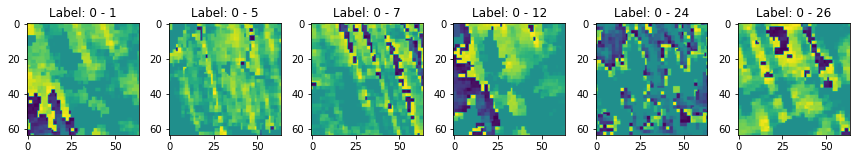

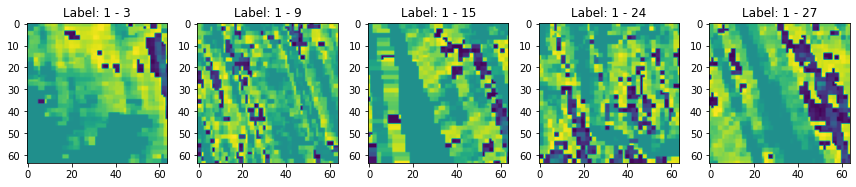

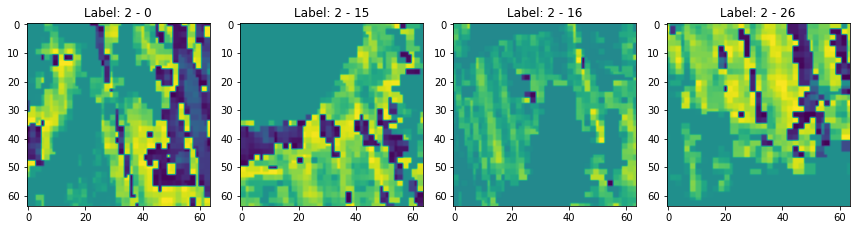

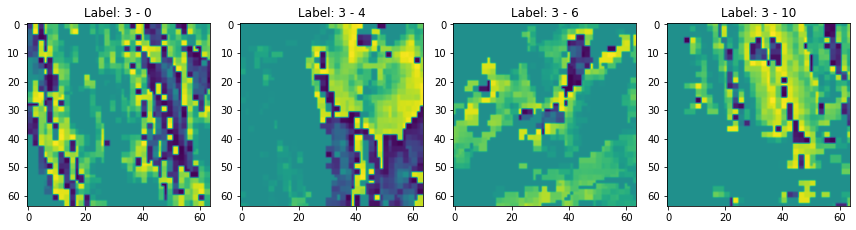

In [18]:
resnet50.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet50(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

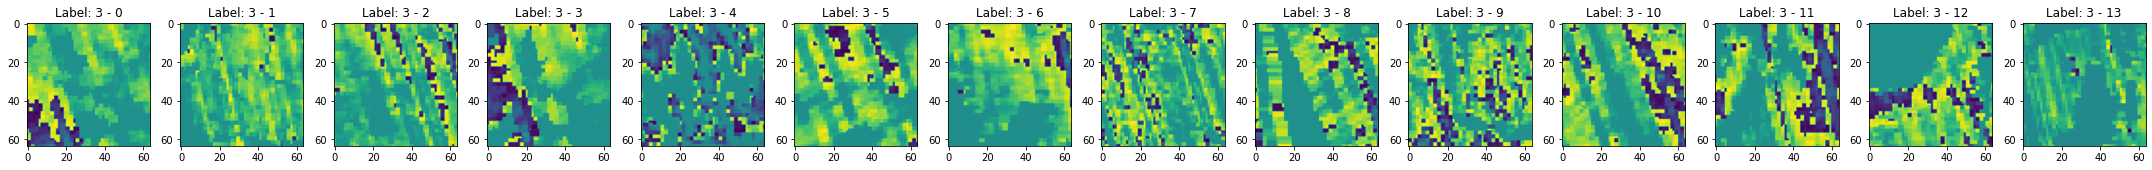

In [21]:
resnet50.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet50(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels) & (labels == 0)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list 
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
true_probabilities = []
predicted_probabilities = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet50(images)
        probabilities = torch.softmax(outputs, dim=1)

        # Collect predicted probabilities and true labels
        predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming binary classification
        true_probabilities.extend(labels.cpu().numpy())

# Compute the AUC
auc = roc_auc_score(true_probabilities, predicted_probabilities)
print(f"Validation AUC: {auc}")

Validation AUC: 0.9268292682926829


## Resnet101

In [7]:
# Define the device for training (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
resnet101 = models.resnet101(weights='ResNet101_Weights.DEFAULT')

# Modify the first layer to accept single-channel grayscale images
resnet101.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last fully connected layer for binary classification with softmax activation
num_classes = 2  # 2 classes: 1 or 0
resnet101.fc = nn.Sequential(
    nn.Linear(resnet101.fc.in_features, num_classes)
)

resnet101.load_state_dict(torch.load('weight/cut_2/resnet101_0.8468468468468469.pth'))
resnet101.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

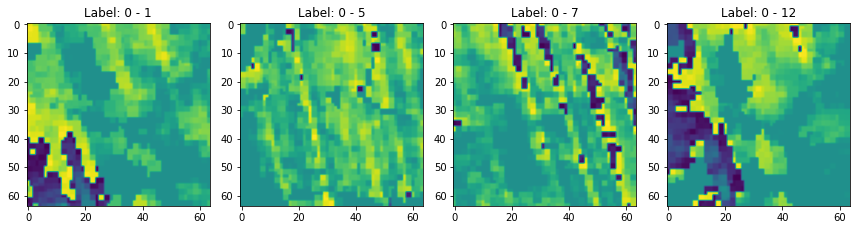

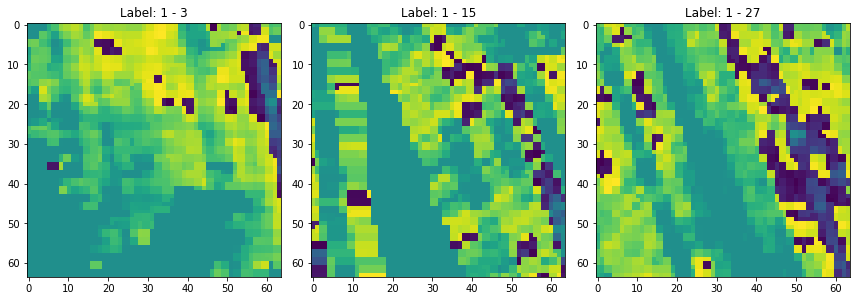

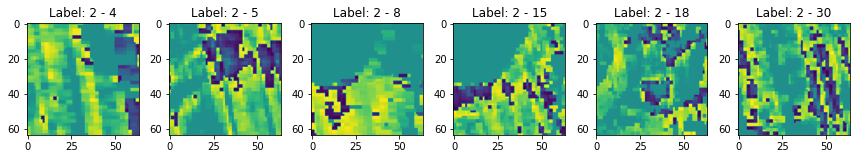

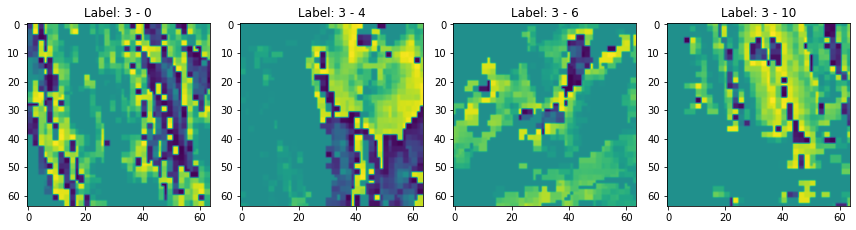

In [10]:
resnet101.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet101(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

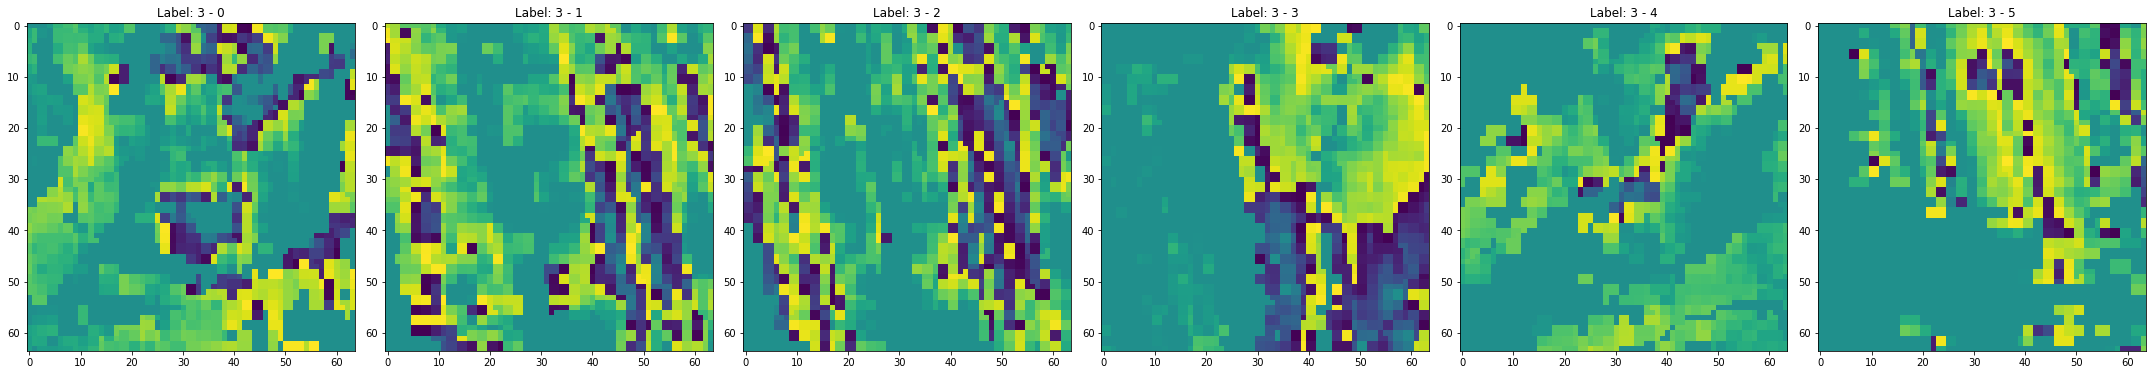

In [15]:
resnet101.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet101(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels) & (labels == 1)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list 
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## EfficientNet

In [27]:
# Load the pre-trained EfficientNet model
efficientnet_model = efficientnet.efficientnet_b7(weights='EfficientNet_B7_Weights.IMAGENET1K_V1')

# Modify the input layer to accept single-channel grayscale images
efficientnet_model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

# Modify the classifier head for binary classification
num_classes = 2  # 2 classes: 1 or 0
in_features = efficientnet_model.classifier[1].in_features
dropout_rate = efficientnet_model.classifier[0].p

# Remove the existing layers in the classifier head
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(in_features, num_classes)
)


efficientnet_model.load_state_dict(torch.load('EfficientNet_0.8372093023255814.pth'))
efficientnet_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

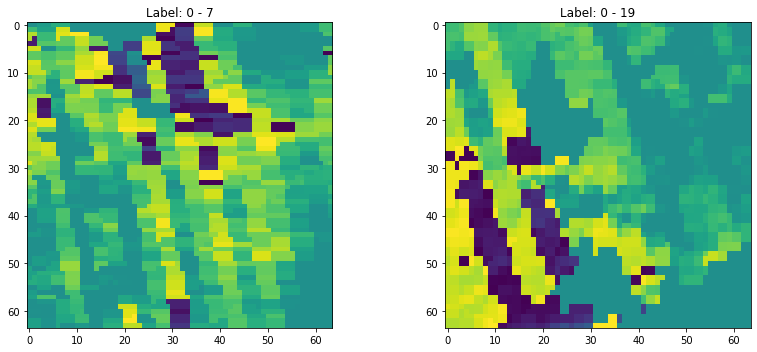

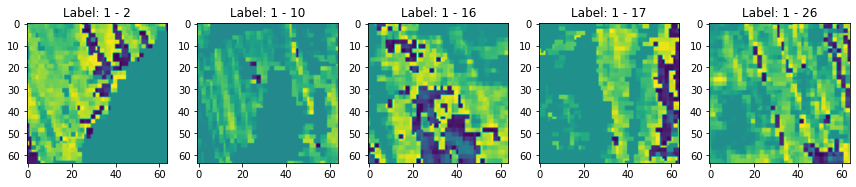

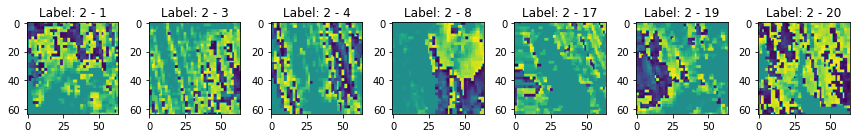

In [33]:
efficientnet_model.eval()

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    
    # Forward pass
    outputs = efficientnet_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    index = predicted == labels
    index = [i  for i, x in enumerate(list(index.cpu().numpy())) if x == False]
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, len(index), figsize=(12, 5))
    for i, idx in enumerate(index):
        image = images[idx]
        # Convert the tensor to a numpy array and reshape it
        image = image.cpu().squeeze().numpy()

        # Display the image
        axes[i].imshow(image, cmap='viridis')
        axes[i].set_title(f"Label: {batch_num} - {idx}")

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

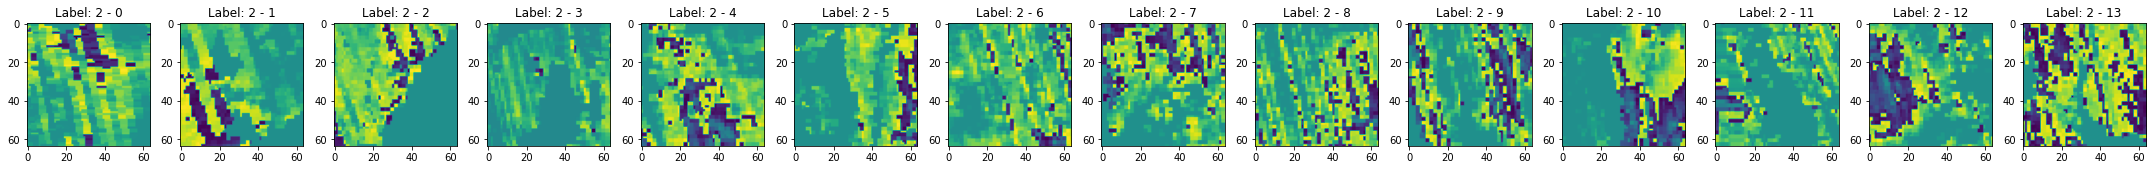

In [40]:
efficientnet_model.eval()

misclassified_images = []  # List to store misclassified images

for batch_num, batch in enumerate(val_loader):
    images, labels = batch
    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)

    # Forward pass
    outputs = efficientnet_model(images)
    _, predicted = torch.max(outputs.data, 1)

    index = (predicted != labels)  # Filter misclassified images with true class equal to 1
    misclassified_indices = [i for i, x in enumerate(index.cpu().numpy()) if x]

    # Add misclassified images to the list
    for idx in misclassified_indices:
        misclassified_images.append(images[idx].cpu().numpy())

# Display the misclassified images
fig, axes = plt.subplots(1, len(misclassified_images), figsize=(30, 10))
for i, image in enumerate(misclassified_images):
    axes[i].imshow(image.squeeze(), cmap='viridis')
    axes[i].set_title(f"Label: {batch_num} - {i}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
